<a href="https://colab.research.google.com/github/yoramabbou770/AICourseRoad2/blob/main/droneExo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# Replace 'your_file.zip' with the actual file name
zip_file_path = '/content/drone_data-20231204T220641Z-001.zip'

# Replace 'extracted_folder' with the desired extraction path
extraction_path = '/content/extracted_folder/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified destination folder
    zip_ref.extractall(extraction_path)

# Check if there's only one item in the extraction path (a folder)
extracted_items = os.listdir(extraction_path)
if len(extracted_items) == 1:
    # If there's only one item, update the extraction path
    extraction_path = os.path.join(extraction_path, extracted_items[0])

# Now 'extraction_path' points to the contents of the extracted folder

In [7]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf

# Define the path to the dataset
dataset_path = "/content/extracted_folder/drone_data/"

# Initialize lists to store processed images and labels
processed_images = []
labels = []

for file_name in os.listdir(dataset_path):
    if file_name.endswith(".txt"):  # Assuming label files end with '.txt'
        # Read bounding box information from the label file (YOLOv8 format)
        with open(os.path.join(dataset_path, file_name), 'r') as label_file:
            # Assuming each line represents a bounding box in YOLOv8 format
            line = label_file.readline().strip().split()
            x_center, y_center, box_width, box_height, confidence = map(float, line)

        # Calculate bounding box coordinates
        img_path = os.path.join(dataset_path, file_name.replace(".txt", ".jpg"))
        img = Image.open(img_path)
        img_width, img_height = img.size

        left = int((x_center - box_width / 2) * img_width)
        top = int((y_center - box_height / 2) * img_height)
        right = int((x_center + box_width / 2) * img_width)
        bottom = int((y_center + box_height / 2) * img_height)

        # Create a new image by cropping the bounding box
        cropped_img = img.crop((left, top, right, bottom))

        # Convert the cropped image to black and white
        cropped_img = cropped_img.convert("L")

        # Resize the image to a quadratic form (e.g., 28x28) using Keras library
        cropped_img = cropped_img.resize((28, 28))

        # Save the processed image in the list along with the appropriate label (drone)
        processed_images.append(np.array(cropped_img))
        labels.append(1)  # Assuming label 1 represents a drone

        # Repeat the above steps, but this time take a random crop of the image
        random_left = np.random.randint(0, img.width - 28)
        random_top = np.random.randint(0, img.height - 28)
        random_right = random_left + 28
        random_bottom = random_top + 28

        random_cropped_img = img.crop((random_left, random_top, random_right, random_bottom))
        random_cropped_img = random_cropped_img.convert("L")
        random_cropped_img = random_cropped_img.resize((28, 28))

        # Save the random cropped image in a separate list along with the appropriate label (not a drone)
        processed_images.append(np.array(random_cropped_img))
        labels.append(0)  # Assuming label 0 represents not a drone

In [8]:
# Convert lists to TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((np.array(processed_images), np.array(labels)))

# Ensure that the shapes and types of images and labels match TensorFlow's requirements
# ...

# Split the dataset into training and testing sets
train_size = int(0.8 * len(processed_images))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [9]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (drone or not)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
model.fit(train_dataset.batch(32), epochs=5)

Epoch 1/5
204/204 [==============================] - 3s 13ms/step - loss: 0.7468 - accuracy: 0.9894
Epoch 2/5
204/204 [==============================] - 3s 17ms/step - loss: 3.1204e-05 - accuracy: 1.0000
Epoch 3/5
204/204 [==============================] - 2s 9ms/step - loss: 1.0015e-04 - accuracy: 1.0000
Epoch 4/5
204/204 [==============================] - 2s 9ms/step - loss: 1.0981e-05 - accuracy: 1.0000
Epoch 5/5
204/204 [==============================] - 2s 9ms/step - loss: 3.9731e-06 - accuracy: 1.0000


In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy}")

51/51 [==============================] - 0s 6ms/step - loss: 1.5488e-08 - accuracy: 1.0000
Test Accuracy: 1.0


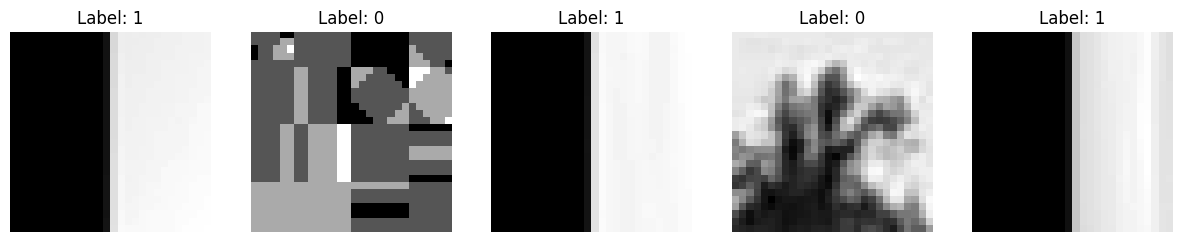

In [12]:
import matplotlib.pyplot as plt

# Plot some images
num_images_to_plot = 5

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    axes[i].imshow(processed_images[i], cmap='gray')  # Assuming images are black and white
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.show()